<a href="https://colab.research.google.com/github/mehkzhra/Image-Classification/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import datasets, transforms

# This will automatically download to ./data if not already present
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True)



100%|██████████| 170M/170M [00:02<00:00, 62.9MB/s]


In [ ]:
print("Training images:", len(train_dataset))
print("Test images:", len(test_dataset))
print("Classes:", train_dataset.classes)



Training images: 50000
Test images: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


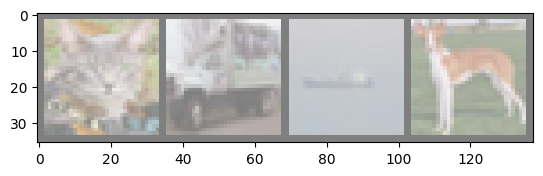

Labels: ['cat', 'truck', 'ship', 'dog']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision # Import torchvision

# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if normalized later
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

from torch.utils.data import DataLoader
from torchvision import transforms

# Apply transform to convert PIL image → Tensor
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Get a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show
imshow(torchvision.utils.make_grid(images))
print('Labels:', [train_dataset.classes[label] for label in labels])

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# CIFAR-10 mean & std (pre-computed)
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),     # random crop with padding
    transforms.RandomHorizontalFlip(),        # 50% chance flip
    transforms.ToTensor(),                    # convert to tensor
    transforms.Normalize(mean, std)           # normalize
])

# Validation/Test (no random changes)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=False, transform=train_transform)

test_dataset = datasets.CIFAR10(root='./data', train=False,
                                download=False, transform=test_transform)



In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


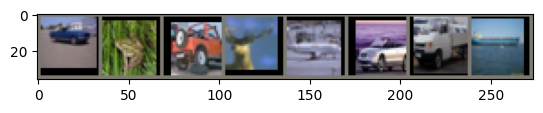

['automobile', 'frog', 'automobile', 'deer', 'airplane', 'automobile', 'truck', 'ship']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = train_dataset.classes

def imshow(img):
    img = img * torch.tensor(std).view(3,1,1) + torch.tensor(mean).view(3,1,1)  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Fetch a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8]))
print([classes[label] for label in labels[:8]])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Conv block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Conv block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Conv block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)   # 10 classes in CIFAR-10

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 128 * 4 * 4)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")


Epoch [1/10] - Loss: 1.6739, Accuracy: 37.42%
Epoch [2/10] - Loss: 1.3804, Accuracy: 49.46%
Epoch [3/10] - Loss: 1.2570, Accuracy: 54.44%
Epoch [4/10] - Loss: 1.1847, Accuracy: 57.43%
Epoch [5/10] - Loss: 1.1210, Accuracy: 60.00%
Epoch [6/10] - Loss: 1.0694, Accuracy: 62.07%
Epoch [7/10] - Loss: 1.0297, Accuracy: 63.40%
Epoch [8/10] - Loss: 0.9939, Accuracy: 64.98%
Epoch [9/10] - Loss: 0.9691, Accuracy: 65.94%
Epoch [10/10] - Loss: 0.9335, Accuracy: 67.11%


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 75.92%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze early layers (optional: keeps pretrained features)
for param in model.parameters():
    param.requires_grad = False

# Replace final fully-connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(DEVICE)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {running_loss/len(train_loader):.4f}, Acc: {acc:.2f}%")


Epoch [1/10] - Loss: 1.8409, Acc: 35.19%
Epoch [2/10] - Loss: 1.7255, Acc: 39.44%
Epoch [3/10] - Loss: 1.7182, Acc: 39.85%
Epoch [4/10] - Loss: 1.7086, Acc: 40.08%
Epoch [5/10] - Loss: 1.7037, Acc: 40.24%
Epoch [6/10] - Loss: 1.6964, Acc: 40.42%
Epoch [7/10] - Loss: 1.6954, Acc: 40.31%
Epoch [8/10] - Loss: 1.7002, Acc: 40.59%
Epoch [9/10] - Loss: 1.7011, Acc: 40.32%
Epoch [10/10] - Loss: 1.7030, Acc: 40.35%


In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 40.22%


In [ ]:
for param in model.parameters():
    param.requires_grad = True  # unfreeze all layers

optimizer = optim.Adam(model.parameters(), lr=1e-4)  # smaller LR


In [ ]:
# Save
torch.save(model.state_dict(), "resnet18_cifar10.pth")

# Load
model.load_state_dict(torch.load("resnet18_cifar10.pth"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    # ---------- Training ----------
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # ---------- Validation ----------
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss /= len(test_loader)
    val_acc = 100 * val_correct / val_total

    # ---------- Save metrics ----------
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")


Epoch 1/10: Train Loss=1.1361, Val Loss=0.8020, Train Acc=60.24%, Val Acc=71.86%
Epoch 2/10: Train Loss=0.7951, Val Loss=0.6640, Train Acc=72.47%, Val Acc=77.14%
Epoch 3/10: Train Loss=0.6786, Val Loss=0.5858, Train Acc=76.60%, Val Acc=79.68%
Epoch 4/10: Train Loss=0.6080, Val Loss=0.5601, Train Acc=78.93%, Val Acc=80.33%
Epoch 5/10: Train Loss=0.5600, Val Loss=0.5303, Train Acc=80.68%, Val Acc=81.69%
Epoch 6/10: Train Loss=0.5134, Val Loss=0.5143, Train Acc=82.02%, Val Acc=82.73%
Epoch 7/10: Train Loss=0.4798, Val Loss=0.5028, Train Acc=83.41%, Val Acc=82.59%
Epoch 8/10: Train Loss=0.4502, Val Loss=0.4774, Train Acc=84.15%, Val Acc=83.92%
Epoch 9/10: Train Loss=0.4259, Val Loss=0.4725, Train Acc=85.15%, Val Acc=84.24%
Epoch 10/10: Train Loss=0.3977, Val Loss=0.4972, Train Acc=86.10%, Val Acc=83.46%


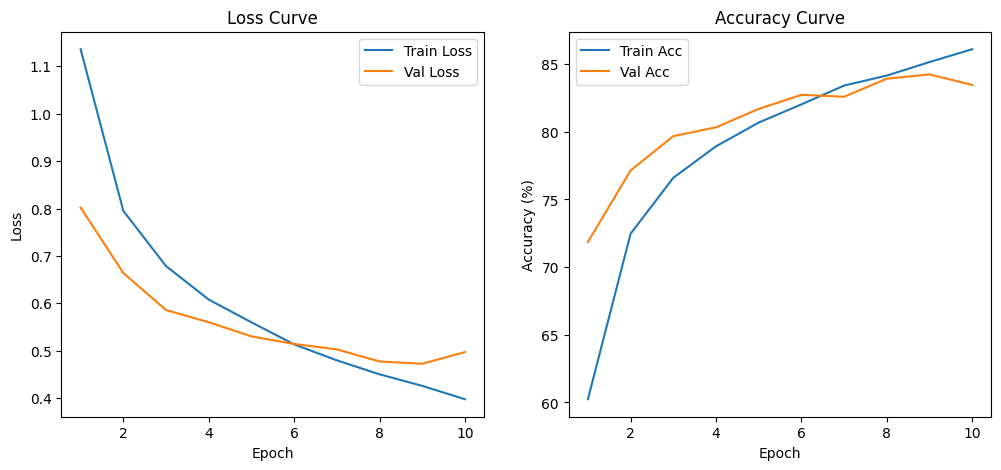

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


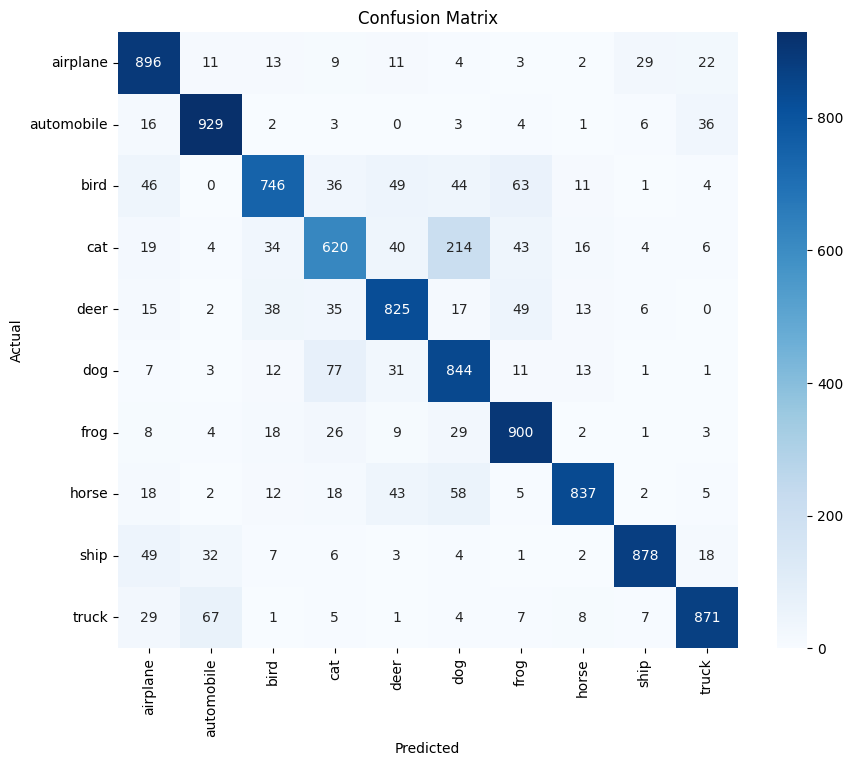

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Collect predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
classes = test_dataset.classes

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


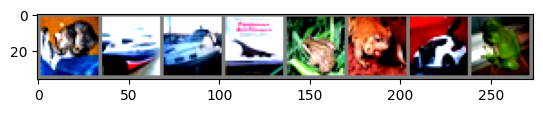

Predicted: ['cat', 'ship', 'automobile', 'airplane', 'frog', 'frog', 'automobile', 'frog']
Actual:    ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog']


In [ ]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(DEVICE))
_, preds = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:8]))
print("Predicted:", [classes[p] for p in preds[:8]])
print("Actual:   ", [classes[l] for l in labels[:8]])
